In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
from keras.applications import VGG16
from keras.models import load_model, Model
from keras.layers import Dense, concatenate, Input, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import importlib as imp

# custom module for capstone 2
import cap2tools as c2t
imp.reload(c2t)

Using TensorFlow backend.


<module 'cap2tools' from 'C:\\Users\\Nils\\Documents\\GitHub\\Springboard-Capstone-2-local-yelp\\cap2tools.py'>

In [2]:
K.clear_session()

In [3]:
# configure GPU memory usage by tensorflow
config = K.tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.90
K.tensorflow_backend.set_session(K.tf.Session(config=config))

In [4]:
# define paths to image directories
photos_path = 'C:/Users/Nils/Documents/GitHub/Springboard-Capstone-2-local-yelp/downsampled/'
train_path = photos_path + 'train'
valid_path = photos_path + 'val'

# build image generators to feed CNN
batch_size = 8
target_size = (224, 224)
shuffle = True
shift = 0.2

# training datagen includes real-time image augmentation
train_datagen = ImageDataGenerator(horizontal_flip=True, 
                                   width_shift_range=shift, 
                                   height_shift_range=shift, 
                                   zoom_range=0.2, 
                                   fill_mode='reflect')

train_batches = train_datagen.flow_from_directory(train_path, 
                                                  target_size=target_size, 
                                                  batch_size=batch_size, 
                                                  shuffle=shuffle)

# validation set datagen
valid_datagen = ImageDataGenerator()

valid_batches = valid_datagen.flow_from_directory(valid_path, 
                                                  target_size=target_size, 
                                                  batch_size=batch_size, 
                                                  shuffle=shuffle)

Found 5435 images belonging to 5 classes.
Found 455 images belonging to 5 classes.


In [5]:
# save weights only for base models
base_model_large = load_model('models/final_model.h5')
base_model_large.save_weights('models/final_model_weights.h5')
del base_model_large

base_model_downsample = load_model('models/downsample_model2.h5')
base_model_downsample.save_weights('models/downsample_model2_weights.h5')
del base_model_downsample

In [5]:
# save weights only for base models
base_model_large = load_model('models/hybrid_training_model_3.h5')
base_model_large.save_weights('models/hybrid_training_model_3_weights.h5')
del base_model_large

base_model_downsample = load_model('models/hybrid_training_model_2.h5')
base_model_downsample.save_weights('models/hybrid_training_model_2_weights.h5')
del base_model_downsample

In [6]:
# rebuild large-dataset model architecture
width = 800
dropout1 = 0
dropout2 = 0.1

base_model = VGG16(include_top=False, 
                   weights=None, 
                   input_shape=(224, 224, 3))

inputs = base_model.output
x = Flatten()(inputs)
x = Dense(width, activation='relu')(x)
x = Dropout(dropout1)(x)
x = Dense(width, activation='relu')(x)
x = Dropout(dropout2)(x)
preds = Dense(5, activation='relu')(x)

base_model_large = Model(inputs=base_model.inputs, outputs=preds)
base_model_large.name = 'large'
del base_model

# load trained weights into model
base_model_large.load_weights('models/hybrid_training_model_3_weights.h5')

# set weights to untrainable
for layer in base_model_large.layers:
    layer.trainable = False

In [7]:
# rebuild downsampled model architecture
width = 800
dropout1 = 0
dropout2 = 0

base_model = VGG16(include_top=False, 
                   weights=None, 
                   input_shape=(224, 224, 3))

inputs = base_model.output
x = Flatten()(inputs)
x = Dense(width, activation='relu')(x)
x = Dropout(dropout1)(x)
x = Dense(width, activation='relu')(x)
x = Dropout(dropout2)(x)
preds = Dense(5, activation='relu')(x)

base_model_downsample = Model(inputs=base_model.inputs, outputs=preds)
base_model_downsample.name = 'downsample'
del base_model

# load trained weights into model
base_model_downsample.load_weights('models/hybrid_training_model_2_weights.h5')

# set weights to untrainable
for layer in base_model_downsample.layers:
    layer.trainable = False

In [8]:
# construct combined model
inputs = Input(shape=(224, 224, 3,), name='main_input')
large_out = base_model_large(inputs)
downsample_out = base_model_downsample(inputs)

# combine outputs of base models into one layer
x = concatenate([large_out, downsample_out])

# new output layer
preds = Dense(5, activation='softmax')(x)

# compile model
model = Model(inputs=inputs, outputs=preds)
model.compile(optimizer=Adam(lr=0.1, decay=0.1), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# clear other models from memory
del base_model_large
del base_model_downsample

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
large (Model)                   (None, 5)            35430693    main_input[0][0]                 
__________________________________________________________________________________________________
downsample (Model)              (None, 5)            35430693    main_input[0][0]                 
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 10)           0           large[1][0]                      
                                                                 downsample[1][0]                 
__________

In [10]:
# define callbacks
savepath = 'models/combined_hybrid_model.h5'
saver = ModelCheckpoint(savepath,
                        monitor='val_loss',
                        verbose=1,
                        save_best_only=True)

stopper = EarlyStopping(monitor='val_loss', 
                        patience=2, 
                        verbose=1)

# train model
n_epochs = 20

history = model.fit_generator(train_batches, 
                              validation_data=valid_batches,
                              epochs=n_epochs, 
                              verbose=1, 
                              callbacks=[saver, stopper])

Epoch 1/20
680/680 [==============================] - 96s 141ms/step - loss: 0.2892 - acc: 0.8993 - val_loss: 0.2846 - val_acc: 0.9209

Epoch 00001: val_loss improved from inf to 0.28461, saving model to models/combined_hybrid_model.h5
Epoch 2/20
680/680 [==============================] - 94s 138ms/step - loss: 0.2761 - acc: 0.9051 - val_loss: 0.2821 - val_acc: 0.9275

Epoch 00002: val_loss improved from 0.28461 to 0.28210, saving model to models/combined_hybrid_model.h5
Epoch 3/20
680/680 [==============================] - 94s 138ms/step - loss: 0.2573 - acc: 0.9040 - val_loss: 0.2844 - val_acc: 0.9187

Epoch 00003: val_loss did not improve from 0.28210
Epoch 4/20
680/680 [==============================] - 94s 138ms/step - loss: 0.2603 - acc: 0.9070 - val_loss: 0.2818 - val_acc: 0.9209

Epoch 00004: val_loss improved from 0.28210 to 0.28180, saving model to models/combined_hybrid_model.h5
Epoch 5/20
680/680 [==============================] - 94s 138ms/step - loss: 0.2669 - acc: 0.9037

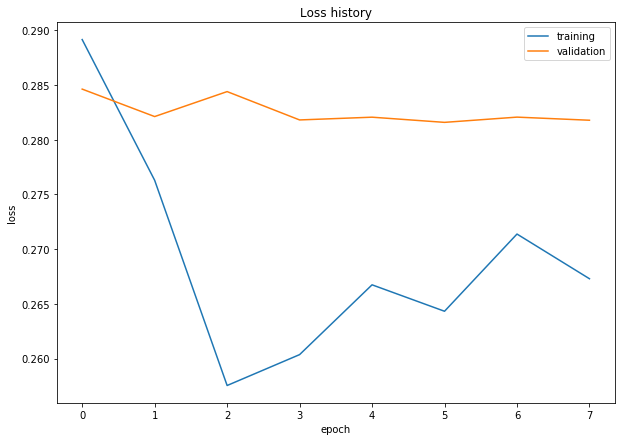

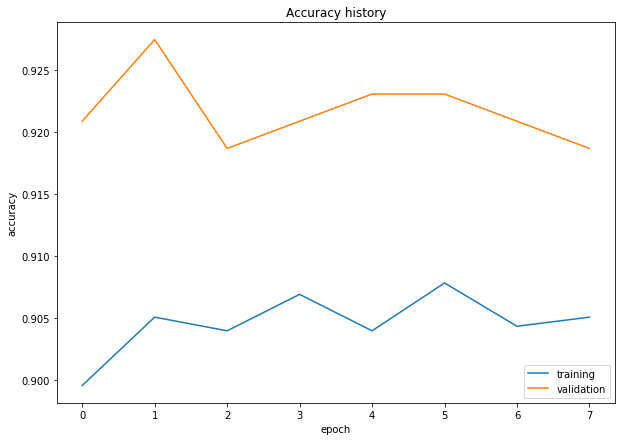

In [11]:
# plot model training history
c2t.plot_history(history)

In [12]:
# evaluate model on larger validation set
model_paths = {'model': savepath}
valid_path_large = 'H:/springboard/other_data/yelp/Photos/final_photos/val'
model_metrics_large = c2t.eval_models(model_paths, valid_path_large)['model']
c2t.print_eval(model_metrics)

Building image generator...
Found 20000 images belonging to 5 classes.
Loading model models/combined_hybrid_model.h5
Evaluating model models/combined_hybrid_model.h5
Evaluation complete.



NameError: name 'model_metrics' is not defined

In [13]:
c2t.print_eval(model_metrics_large)

accuracy: 0.9215
loss: 0.24133280927917813
pcr: [0.92241379 0.94942966 0.85294118 1.         0.87766281]
mean pcr: 0.9204894878596221
confusion matrix:


[[642, 28, 22, 2, 2],
 [378, 12485, 146, 53, 88],
 [72, 51, 3770, 19, 508],
 [0, 0, 0, 91, 0],
 [5, 6, 179, 11, 1442]]

In [11]:
# evaluate model on downsampled val set
model_paths = {'model': savepath}
model_metrics = c2t.eval_models(model_paths, valid_path)['model']

Building image generator...
Found 455 images belonging to 5 classes.
Loading model models/combined_model.h5
Evaluating model models/combined_model.h5
Evaluation complete.



In [12]:
c2t.print_eval(model_metrics)

accuracy: 0.9164835166145157
loss: 0.2367583004123247
pcr: [0.86813187 0.95604396 0.91208791 0.98901099 0.85714286]
mean pcr: 0.9164835164835164
confusion matrix:


[[79, 6, 5, 0, 1],
 [2, 87, 0, 1, 1],
 [3, 2, 83, 1, 2],
 [0, 0, 1, 90, 0],
 [0, 1, 12, 0, 78]]

In [13]:
# evaluate model on larger validation set
valid_path_large = 'H:/springboard/other_data/yelp/Photos/final_photos/val'
model_metrics_large = c2t.eval_models(model_paths, valid_path_large)['model']

Building image generator...
Found 20000 images belonging to 5 classes.
Loading model models/combined_model.h5
Evaluating model models/combined_model.h5
Evaluation complete.



In [14]:
c2t.print_eval(model_metrics_large)

accuracy: 0.92055
loss: 0.2234197325780282
pcr: [0.91954023 0.94653992 0.85904977 0.98901099 0.8746196 ]
mean pcr: 0.9177521029803751
confusion matrix:


[[640, 28, 24, 1, 3],
 [416, 12447, 162, 33, 92],
 [70, 56, 3797, 20, 477],
 [0, 0, 1, 90, 0],
 [6, 7, 182, 11, 1437]]

In [15]:
# evaluate large model on large validation set, for comparison
model_paths_large = {'model': 'models/final_model.h5'}
model_metrics_large = c2t.eval_models(model_paths_large, valid_path_large)['model']

Building image generator...
Found 20000 images belonging to 5 classes.
Loading model models/final_model.h5
Evaluating model models/final_model.h5
Evaluation complete.



In [16]:
c2t.print_eval(model_metrics_large)

accuracy: 0.9418
loss: 0.1670943652353014
pcr: [0.67097701 0.98859316 0.92466063 0.47252747 0.75410834]
mean pcr: 0.7621733223609561
confusion matrix:


[[467, 155, 63, 1, 10],
 [77, 13000, 66, 1, 6],
 [27, 122, 4087, 4, 180],
 [1, 13, 16, 43, 18],
 [6, 23, 373, 2, 1239]]

In [17]:
# evaluate downsampled model on large validation set, for comparison
model_paths_down = {'model': 'models/downsample_model.h5'}
model_metrics_down = c2t.eval_models(model_paths_down, valid_path_large)['model']

Building image generator...
Found 20000 images belonging to 5 classes.
Loading model models/downsample_model.h5
Evaluating model models/downsample_model.h5
Evaluation complete.



In [18]:
c2t.print_eval(model_metrics_down)

accuracy: 0.88075
loss: 0.32189788192114427
pcr: [0.9066092  0.90547529 0.81153846 0.95604396 0.85392575]
mean pcr: 0.886718528748632
confusion matrix:


[[631, 23, 35, 4, 3],
 [856, 11907, 190, 85, 112],
 [79, 60, 3587, 33, 661],
 [2, 0, 0, 87, 2],
 [12, 4, 208, 16, 1403]]